# cube

In [1]:
# Loading the dataset function
from dataset_functions import *
from PCA_functions import *

## Data split

In [2]:
# Splitting the Dataset: 33% training - 5% Validation - 56% Testing
# Training set is balanced
training = [1,3,8,11,17,22,23,24,25,32,34,44,45,47,49,50,52,53]
validation = [18, 37, 42] 
testing = [2, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 19, 20, 21, 26, 27, 28, 29, 30, 31, 33, 36, 38, 39, 40, 41, 43, 46, 48, 51]

# Reading the data

In [2]:
# Training PCA

# Initialize empty lists to store training data
Training_cube = []
Training_masks = []

# Iterate over training data
for i in range(126):
    """
    Load the PCA-transformed training data and corresponding segmentation masks from respective files
    """
    # Define loading path
    # saving_path =  "PCBDataset/cube/train/"     # e.g.,: /home/PCBvision/PCA/train/
    saving_path =  "D:/cube/train/"     # e.g.,: /home/PCBvision/PCA/train/

    # Construct the filename for the PCA-transformed cube
    header_file = f"{saving_path}{i}.hdr"
    # Construct file paths for PCA data and mask
    data_file = header_file[:-4]

    # Open the PCA data file and extract the PCA-transformed hyperspectral image
    numpy_ndarr = envi.open(header_file, data_file)
    c = spi.io.bipfile.BipFile.open_memmap(numpy_ndarr)
    Training_cube.append(c)

    # Open the mask file and load the segmentation mask
    mask_file = f"{saving_path}{i}.npy"
    m = np.load(mask_file, mmap_mode='r')
    Training_masks.append(m)

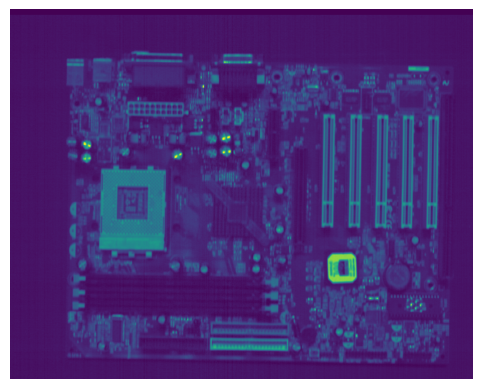

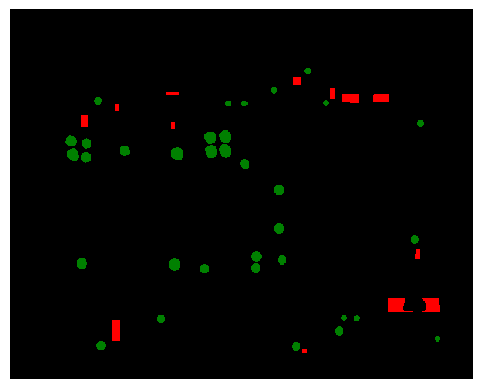

In [4]:
# Training patch visualization
i = 52
plt.imshow(Training_cube[i][:,:,[21]])
plt.axis('off')
plt.figure()
visualize(Training_masks[i])

In [3]:
# Load validation patches and masks
Validation_cube = []  # List to store validation patches
Validation_masks = []  # List to store validation masks


# Iterate over training data
for i in range(3):


    saving_path =  "D:/cube/validation/"     # e.g.,: /home/PCBvision/PCA/train/


    header_file = f"{saving_path}{i}.hdr"
    # Construct file paths for PCA data and mask
    data_file = header_file[:-4]


    # Open the header file and data file using the Envi library
    numpy_ndarr = envi.open(header_file, data_file)
    c = spi.io.bipfile.BipFile.open_memmap(numpy_ndarr)
    # Append the loaded patch to the list of validation patches
    Validation_cube.append(c)


    mask_file = f"{saving_path}{i}.npy"
    m = np.load(mask_file, mmap_mode='r')

    Validation_masks.append(m)

print(len(Validation_cube))
print(len(Validation_masks))

3
3


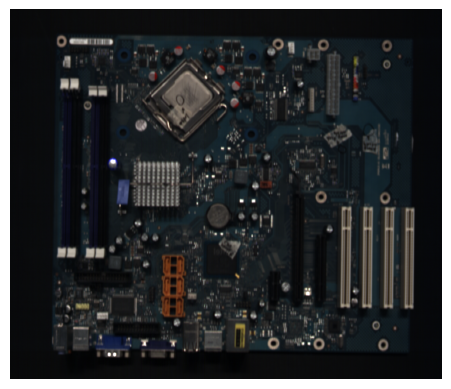

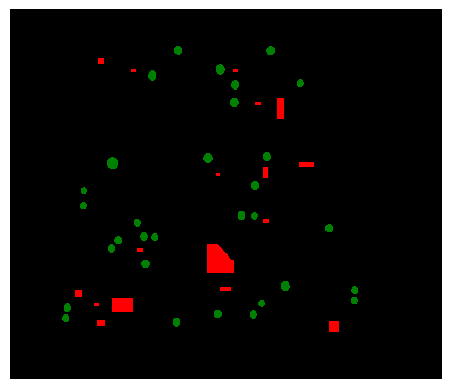

In [6]:
# Validation patch visualization
i = 1
plt.imshow(Validation_cube[i][:,:,(90,55,32)])
plt.axis('off')
plt.figure()
visualize(Validation_masks[i])

In [4]:
# Testing patches loading
Testing_cube = []  # List to store testing patches
Testing_masks = []  # List to store testing masks

# If using the monoseg annotations, don't forget to load them too !!

# Iterate over 690 testing patches
for i in range(30):

    # Define loading path
    # saving_path =  "PCBDataset/cube/test/"     # e.g.,: /home/PCBvision/PCA/train/
    saving_path =  "D:/cube/test/"     # e.g.,: /home/PCBvision/PCA/train/

    # Construct the filename for the PCA-transformed cube
    header_file = f"{saving_path}{i}.hdr"
    # Construct file paths for PCA data and mask
    data_file = header_file[:-4]

    # Open the PCA data file and extract the PCA-transformed hyperspectral image
    numpy_ndarr = envi.open(header_file, data_file)
    c = spi.io.bipfile.BipFile.open_memmap(numpy_ndarr)
    Testing_cube.append(c)

    # Open the mask file and load the segmentation mask
    mask_file = f"{saving_path}{i}.npy"
    m = np.load(mask_file, mmap_mode='r')
    Testing_masks.append(m)

print(len(Testing_cube))
print(len(Testing_masks))

30
30


In [8]:
# Training - validation - testing sets check
len(Training_cube), len(Training_masks), len(Validation_cube), len(Validation_masks), len(Testing_cube), len(Testing_masks)

(126, 126, 3, 3, 30, 30)

# Resizing

In [5]:
Training_cube, Training_masks2 = resize_hyperspectral_images(Training_cube,Training_masks,640)
Training_cube[0].shape, Training_masks2[0].shape, Training_masks[0].shape

((640, 640, 214), (640, 640), (272, 499))

In [6]:
Validation_cube, Validation_masks2 = resize_hyperspectral_images(Validation_cube, Validation_masks,640)
Validation_cube[0].shape, Validation_masks2[0].shape,Validation_masks[0].shape

((640, 640, 214), (640, 640), (370, 560))

In [7]:
Testing_cube, Testing_masks2 = resize_hyperspectral_images(Testing_cube, Testing_masks,640)
Testing_cube[0].shape, Testing_masks2[0].shape, Testing_masks[0].shape

((640, 640, 214), (640, 640), (1100, 1024))

# Deep Learning Part

In [8]:
# Training - validation - testing sample size check
Training_cube[0].shape, Training_masks2[0].shape, Validation_cube[0].shape, Validation_masks2[0].shape, Testing_cube[0].shape, Testing_masks2[0].shape

((640, 640, 214),
 (640, 640),
 (640, 640, 214),
 (640, 640),
 (640, 640, 214),
 (640, 640))

In [9]:
class CustomDataset(Dataset):
    def __init__(self, images, masks):
        # Initialize the dataset with the input images and masks
        self.images = images
        self.masks = masks

    def __len__(self):
        # Return the length of the dataset, which is the number of input images
        return len(self.images)

    def __getitem__(self, index):
        # Retrieve the image and mask corresponding to the given index
        image = self.images[index]
        mask = self.masks[index]

        # Convert the image and mask to torch tensors
        # The `torch.from_numpy()` function converts the numpy arrays to tensors
        # The `.float()` attribute converts the tensors to floating-point format
        # The `torch.as_tensor()` function converts the mask to a long tensor
        image = torch.from_numpy(image.copy()).float()
        mask = torch.from_numpy(mask.copy()).float()
        mask = torch.as_tensor(mask, dtype=torch.long)
        
        return image, mask

### learning with Various Convolutional Models

In [27]:
from models.Unet import UNET
from models.Unet_Attention import AttU_Net
from models.ResUnet import ResUnet

from models.End2End_Unet import End2EndUNet
from models.End2End_ResUnet import End2EndResUnet
from models.End2End_AttUnet import End2EndAttUnet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


device = set_gpu(0)

# Set up the hyperparameters and configuration
num_classes = 4  # Number of output classes
batch_size = 4  # Batch size for training
learning_rate = 0.00005  # Learning rate for the optimizer
num_epochs = 100  # Number of training epochs
patience = 20  # Number of epochs to wait for improvement before early stopping

# Define class weights to handle class imbalance
class_weights = [.1, .7, .95, .8]  # Weights for each class
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # Convert weights to tensors and move to device


# Option 1: U-Net
# model = UNET(
#         in_channels = 214,
#         out_channels = num_classes
# )

# Option 2: Attention U-Net
# model = AttU_Net(
#         img_ch=214,
#         output_ch=num_classes
# )

# Option 3: ResU-Net
# model = ResUnet(
#         channel=214,
#         out_channel=num_classes
# )


# Option 4: End2End Unet
# model = End2EndUNet(
#         spec_in = 214,
#         spec_hidden = 128,
#         spec_out = 3,
#         num_classes = 4,
#         unet_features = [64, 128, 256, 512]
# )

# # Option 5: End2End Attention Unet
# model = End2EndAttUnet(
#         spec_in = 214,
#         spec_hidden = 128,
#         spec_out = 3,
#         num_classes = 4,
#
# )
#
# # Option 6: End2End ResUnet
model = End2EndResUnet(
        spec_in = 214,
        spec_hidden = 128,
        spec_out = 3,
        num_classes = 4,
        Resnet_features = [64, 128, 256, 512]
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define training, validation, and testing datasets
train_dataset = CustomDataset(Training_cube, Training_masks2)
val_dataset = CustomDataset(Validation_cube, Validation_masks2)
test_dataset = CustomDataset(Testing_cube, Testing_masks2)

# Create data loaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, pin_memory=True)

# Specify the path to save the model weights
path = 'End2End_ResUnet.pth'

print("Model Architecture:")
print(model)
# print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
# print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
#
# # Print model input/output shapes for verification
# dummy_input = torch.randn(1, 214, 64, 64).to(device)  # Example input shape
# with torch.no_grad():
#     dummy_output = model(dummy_input)
#     print(f"\nInput shape: {dummy_input.shape}")
#     print(f"Output shape: {dummy_output.shape}")
#
# # Example of how to check intermediate spectral processing
# print(f"\nSpectral processing: 214 channels -> {spectral_reduction_channels} channels")

Model Architecture:
End2EndResUnet(
  (reducer): SpectralReducer(
    (net): Sequential(
      (0): Conv2d(214, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (resnet): ResUnet(
    (input_layer): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (input_skip): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (residual_conv_1): ResidualConv(
      (conv_block): Sequential(
        (0

## Training phase

In [60]:
epochs_without_improvement = 0

# Training loop initialization
best_epoch = 0  # Stores the epoch with the best validation loss so far
best_val_loss = float('inf')  # Stores the minimum validation loss so far

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    train_loss = 0.0  # Initialize the training loss
    
    # Iterate over training batches
    for images, masks in train_loader:
        
        # Zero gradients for optimizer
        optimizer.zero_grad()

        # Move the data to GPU
        images = images.to(device)
        masks = masks.to(device)

        # Remove the channel dimension from masks
        masks = torch.squeeze(masks, dim=1)
        # Convert masks to one-hot encodings and match output shape
        masks = torch.nn.functional.one_hot(masks, num_classes)
        
        # Correct the dimension order: (batch, row, col , channel) --> (batch, channel, row, col)
        masks = masks.permute(0, 3,1,2)  # (16, 640, 640, 4) --> (16, 4, 640, 640)
        images = images.permute(0, 3,1,2)  # (16, 128, 640, 640) --> (16, 214, 640, 640)
        
        # Masks must be float
        masks = masks.type(torch.FloatTensor).to(device)
    
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, masks)

        # Backpropagation and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
        
        # Accumulate training loss
        train_loss += loss.item()




    # Print the average training loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}")
    train_losses.append(train_loss / len(train_loader))


    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize the validation loss
    
    # Disable gradient calculation (not needed for validation)
    with torch.no_grad():
        for images, masks in val_loader:
            # Move the data to GPU
            images = images.to(device)
            masks = masks.type(torch.LongTensor)
            masks = masks.to(device)

            # Remove the channel dimension from masks
            masks = torch.squeeze(masks, dim=1)
            
            # Convert masks to one-hot encodings and match output shape
            masks = torch.nn.functional.one_hot(masks, num_classes)
            masks = masks.permute(0, 3, 1, 2)
            # For some reason the type has to be confirmed to float before the needed step, otherwise an error was generated
            masks = masks.type(torch.FloatTensor)

            images = images.permute(0, 3, 1, 2)

            # Forward pass
            outputs = model(images).to(device)
            
            # For some reason moving to the device has to be confirmed, otherwise an error was generated
            # Move masks to the same device as outputs
            masks = masks.to(outputs.device)
            criterion = criterion.to(device)
            
            # Calculate validation loss
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    # Print average validation loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss / len(val_loader):.4f}")
    val_losses.append(val_loss / len(val_loader))

    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        # Update best validation loss and epoch
        best_val_loss = val_loss
        best_epoch = epoch

        # Reset early stopping counter
        epochs_without_improvement = 0
        
        # Save model weights
        torch.save(model.state_dict(), path)
        print(f"Best Epoch so far [{epoch+1}/{num_epochs}], Best Validation Loss so far: {val_loss / len(val_loader):.4f}")
    else:
        # Increment early stopping counter
        epochs_without_improvement += 1
    
    # Trigger early stopping if there are no improvements for `patience` epochs
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in {patience} epochs.")
        break

# Print best epoch and corresponding validation loss
print(f"Best Epoch: {best_epoch + 1}, Best Validation Loss: {best_val_loss / len(val_loader):.4f}")

KeyboardInterrupt: 

Loss visualization


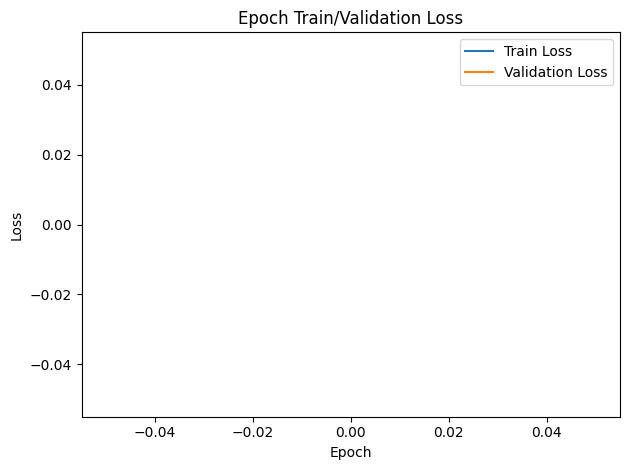

In [61]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Train/Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
print("train")
print(train_losses)
print("val")
print(val_losses)

train
[]
val
[]


## Testing phase

In [28]:


model.load_state_dict(torch.load(path))

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model in evaluation mode: disables certain training-related features
model.eval()

# Initialize lists to store predicted masks
predicted_masks = []

# Iterate over the test images and their ground truth masks
for images, masks in test_loader:
        
    # Move the data to GPU
    images = images.to(device)  # Transfer the image data to the specified device
    masks = masks.type(torch.LongTensor)  # Convert the ground truth masks to LongTensor format
    masks = masks.to(device)  # Transfer the ground truth masks to the specified device

    # Remove the channel dimension from masks: Flatten the masks to remove the channel dimension
    masks = torch.squeeze(masks, dim=1)
            
    # To make the masks have same shape and style as the output of the model
    masks = torch.nn.functional.one_hot(masks, num_classes) # Convert the masks to one-hot encodings
    masks = masks.permute(0, 3, 1, 2)  # Transpose the masks to match the expected output shape
    images = images.permute(0, 3, 1, 2)  # Transpose the images to match the expected input shape
    masks = masks.type(torch.FloatTensor)  # Convert the masks to FloatTensor format
    
    # Perform inference
    with torch.no_grad():  # Forward pass the images through the model to obtain the predictions
        output = model(images)  # Forward pass the images through the model to obtain the predictions 
            
    # Remove batch dimension
    output = torch.squeeze(output, dim=0)  # (1, 4, 128, 128) --> (4, 128, 128)
    output = torch.nn.functional.softmax(output, dim=0)
    output = torch.argmax(output, dim=0)
    
    # Transfer the output to CPU memory and convert it to a numpy array
    predicted_mask = output.cpu().numpy()  
    
    # Append the predicted mask to the list
    predicted_masks.append(predicted_mask)

In [16]:
# Size & Dimension Checks
len(predicted_masks),len(Testing_masks), predicted_masks[0].shape, Testing_masks2[0].shape

(30, 30, (640, 640), (640, 640))

End2EndResUnet(
  13.07 M, 100.000% Params, 517.73 GMac, 99.936% MACs, 
  (reducer): SpectralReducer(
    28.04 k, 0.215% Params, 11.54 GMac, 2.227% MACs, 
    (net): Sequential(
      28.04 k, 0.215% Params, 11.54 GMac, 2.227% MACs, 
      (0): Conv2d(27.39 k, 0.210% Params, 11.22 GMac, 2.166% MACs, 214, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, 0.002% Params, 104.86 MMac, 0.020% MACs, 128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(0, 0.000% Params, 52.43 MMac, 0.010% MACs, inplace=True)
      (3): Conv2d(384, 0.003% Params, 157.29 MMac, 0.030% MACs, 128, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(6, 0.000% Params, 2.46 MMac, 0.000% MACs, 3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(0, 0.000% Params, 1.23 MMac, 0.000% MACs, inplace=True)
    )
  )
  (resnet): ResUnet(
    13.04 M, 99.785% Params, 506.19 GMac, 97.709% MACs, 
    (input_layer): 

(-0.5, 639.5, 639.5, -0.5)

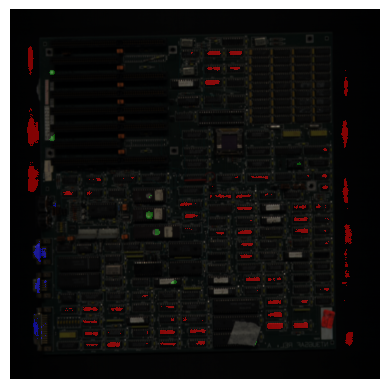

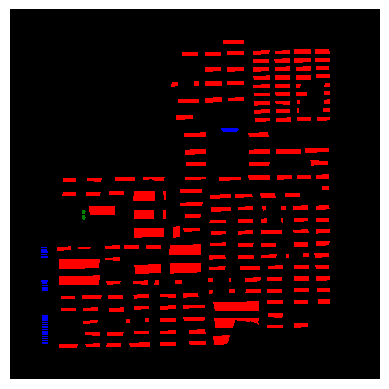

In [35]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(model, (214, 640, 640))
print(flops)
print(params)

i = 0
visualize(predicted_masks[i])
# plt.axis('off')
plt.imshow(Testing_cube[i][:,:,(88,57,29)],alpha = 0.5)
plt.figure()
visualize(Testing_masks2[i])
plt.axis('off')
# plt.imshow(Testing_cube[i][:,:,(88,57,29)],alpha = 0.5)

## Evaluation phase

In [34]:
# Convert the list to a numpy array
predicted_masks2 = np.array(predicted_masks)

# Caculate the segmentation metrics
confusion_matrix_sum, true_positive_sum, true_negative_sum, false_positive_sum, false_negative_sum, precision, recall, f1_score, pixel_accuracy_per_class, pixel_accuracy, iou, dice_coefficient, kappa = evaluate_segmentation(Testing_masks2, predicted_masks2, num_classes)

# Print the evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix_sum)
print("Pixel Accuracy:")
print(pixel_accuracy)
print("Precision:")
print(precision)
print("Recall:")
print(recall)
print("F1 Score:")
print(f1_score)
print("Intersection over Union (IoU):")
print(iou)
print("Dice Coefficient:")
print(dice_coefficient)
print("Kappa Coefficient:")
print(kappa)


Confusion Matrix:
[[10545106   186011    32195   507775]
 [  227791   630697     4004      111]
 [    4118       82    27421      140]
 [    6573        0        4   115972]]
Pixel Accuracy:
0.9211585286458334
Precision:
[0.97788473 0.77216543 0.43098516 0.18585316]
Recall:
[0.93558909 0.73115558 0.86335443 0.94633167]
F1 Score:
[0.95626945 0.75110114 0.57495413 0.31068908]
Intersection over Union (IoU):
[0.91620338 0.6014107  0.4034636  0.18391468]
Dice Coefficient:
[0.95626945 0.75110114 0.57495413 0.31068908]
Kappa Coefficient:
[0.49158614 0.91570784 0.92097036 0.92042751]
